In [2]:
!pip install -q tqdm


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 16
EPOCHS = 10
LATENT_DIM = 100
NUM_CLASSES = 10
IMAGE_SIZE = 32
LABELS = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Seed
tf.random.set_seed(2024)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


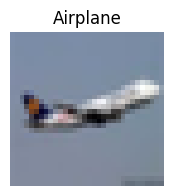

In [4]:
# Load data
(train_images, train_labels), (_, _) = cifar10.load_data()

# Normalize to [-1, 1]
train_images = (train_images.astype(np.float32) - 127.5) / 127.5

# Create tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data = train_data.shuffle(1000).batch(BATCH_SIZE)

# Show a random image
plt.figure(figsize=(2, 2))
random_index = np.random.randint(len(train_images))
sample_image = image.array_to_img(train_images[random_index], scale=True)
plt.imshow(sample_image)
plt.axis('off')
plt.title(LABELS[train_labels[random_index][0]])
plt.show()


In [5]:
# Binary cross-entropy loss
bce = losses.BinaryCrossentropy()

def loss_disc(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def loss_gen(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

# Optimizers
opt_d = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
opt_g = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [6]:
# Generator
def create_generator():
    label_input = layers.Input(shape=(1,))
    label_embed = layers.Embedding(NUM_CLASSES, 50)(label_input)
    label_dense = layers.Dense(8 * 8)(label_embed)
    label_reshape = layers.Reshape((8, 8, 1))(label_dense)

    noise_input = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(128 * 8 * 8)(noise_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Concatenate()([x, label_reshape])
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    output_image = layers.Conv2D(3, kernel_size=8, padding='same', activation='tanh')(x)
    return models.Model([noise_input, label_input], output_image, name="GenModel")

# Discriminator
def create_discriminator():
    label_input = layers.Input(shape=(1,))
    label_embed = layers.Embedding(NUM_CLASSES, 50)(label_input)
    label_dense = layers.Dense(IMAGE_SIZE * IMAGE_SIZE)(label_embed)
    label_reshape = layers.Reshape((IMAGE_SIZE, IMAGE_SIZE, 1))(label_dense)

    image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Concatenate()([image_input, label_reshape])
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    validity = layers.Dense(1, activation='sigmoid')(x)
    return models.Model([image_input, label_input], validity, name="DiscModel")

# Create models
generator = create_generator()
discriminator = create_discriminator()

generator.summary()
discriminator.summary()


Model: "GenModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8192)      │    827,392 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8192)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 64)     │      3,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 128) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    262,272 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 3) │     24,579 │ leaky_re_lu_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,382,327 (5.27 MB)

 Trainable params: 1,382,327 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

Model: "DiscModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1024)   │     52,224 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 4) │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,736 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      8,193 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,237 (832.96 KB)

 Trainable params: 213,237 (832.96 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
@tf.function
def step(real_imgs, real_labels):
    # Train discriminator
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    fake_imgs = generator([noise, real_labels], training=True)

    with tf.GradientTape() as d_tape:
        real_pred = discriminator([real_imgs, real_labels], training=True)
        fake_pred = discriminator([fake_imgs, real_labels], training=True)
        d_loss = loss_disc(real_pred, fake_pred)

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    opt_d.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_imgs = generator([noise, real_labels], training=True)
        validity = discriminator([generated_imgs, real_labels], training=True)
        g_loss = loss_gen(validity)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    opt_g.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


In [8]:
def display_generated(num_per_class=4):
    fig, axes = plt.subplots(NUM_CLASSES, num_per_class, figsize=(num_per_class * 2, NUM_CLASSES * 2))
    for label in range(NUM_CLASSES):
        noise = tf.random.normal([num_per_class, LATENT_DIM])
        labels_input = tf.constant(label, shape=(num_per_class, 1))
        generated = generator.predict([noise, labels_input], verbose=0)

        for i in range(num_per_class):
            axes[label, i].imshow(image.array_to_img(generated[i], scale=True))
            axes[label, i].axis('off')
            if i == 0:
                axes[label, i].set_ylabel(LABELS[label])
    plt.tight_layout()
    plt.show()



📦 Epoch 1/10


100%|██████████| 3125/3125 [00:51<00:00, 61.22it/s]


Generator Loss: 0.8897 | Discriminator Loss: 1.2956
⏱️ Time: 51.29s


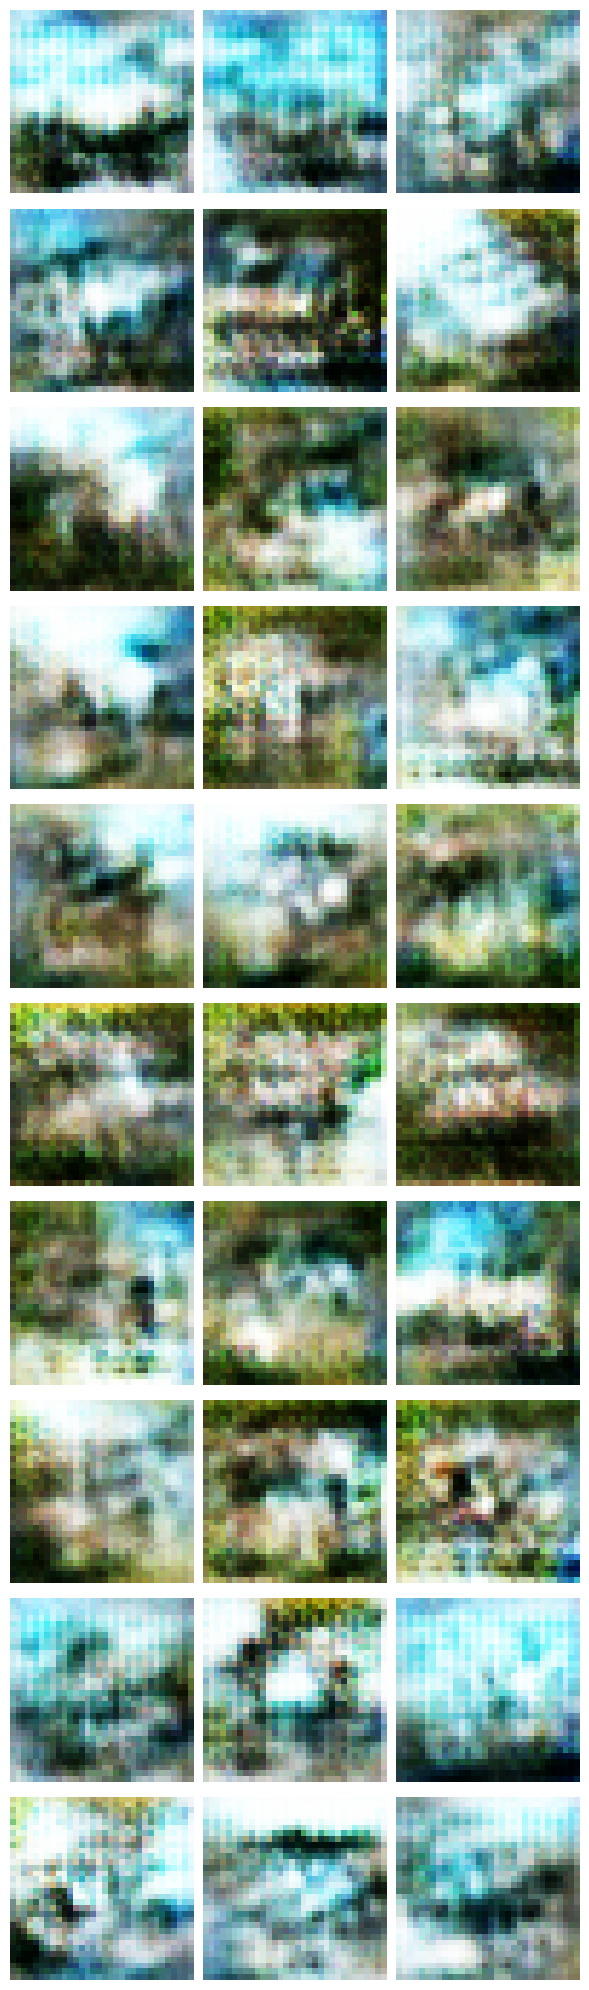


📦 Epoch 2/10


100%|██████████| 3125/3125 [00:44<00:00, 70.00it/s]


Generator Loss: 0.8029 | Discriminator Loss: 1.3386
⏱️ Time: 44.98s


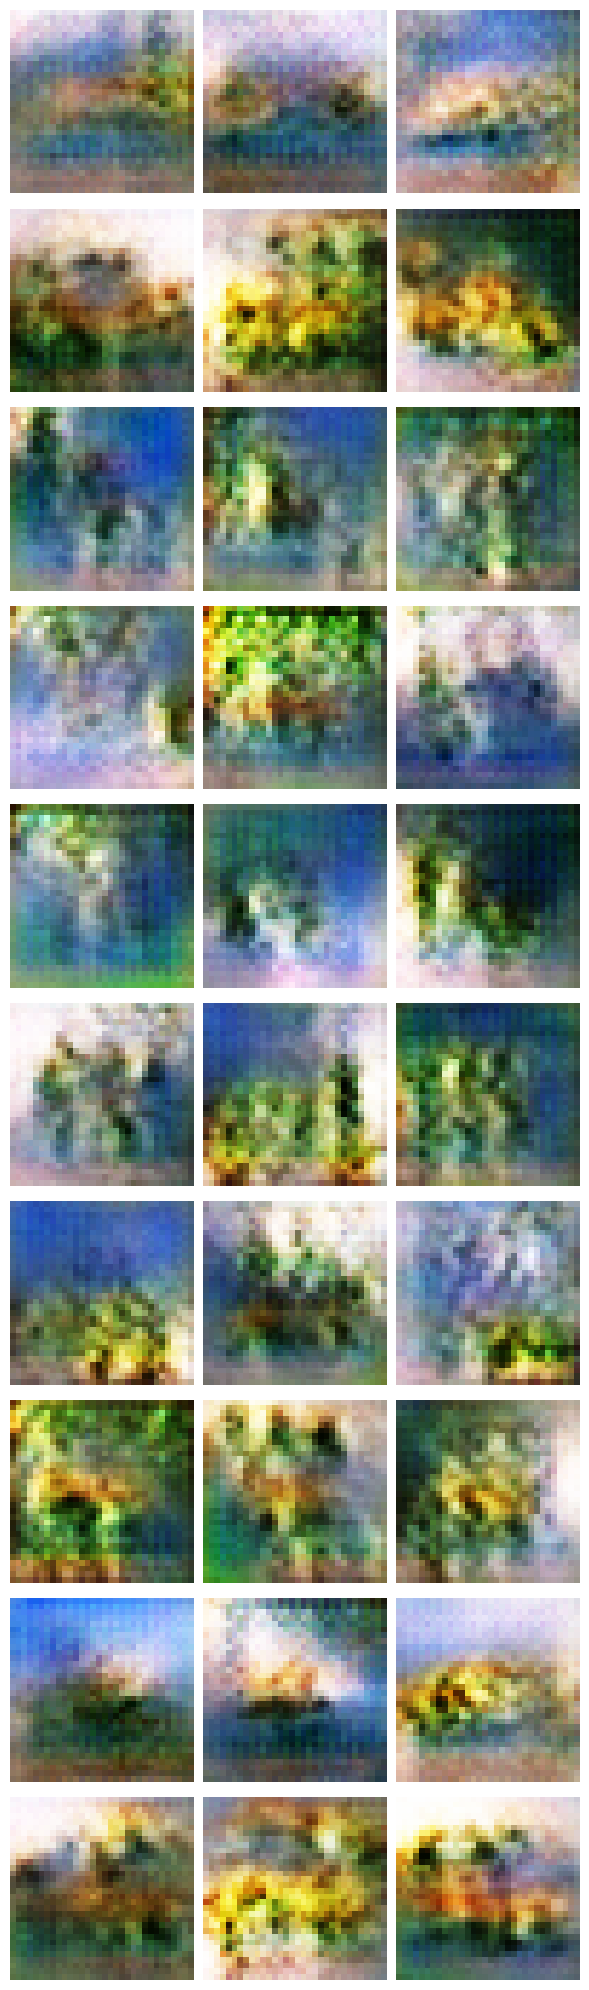


📦 Epoch 3/10


100%|██████████| 3125/3125 [00:44<00:00, 70.05it/s]


Generator Loss: 0.7959 | Discriminator Loss: 1.3408
⏱️ Time: 44.87s


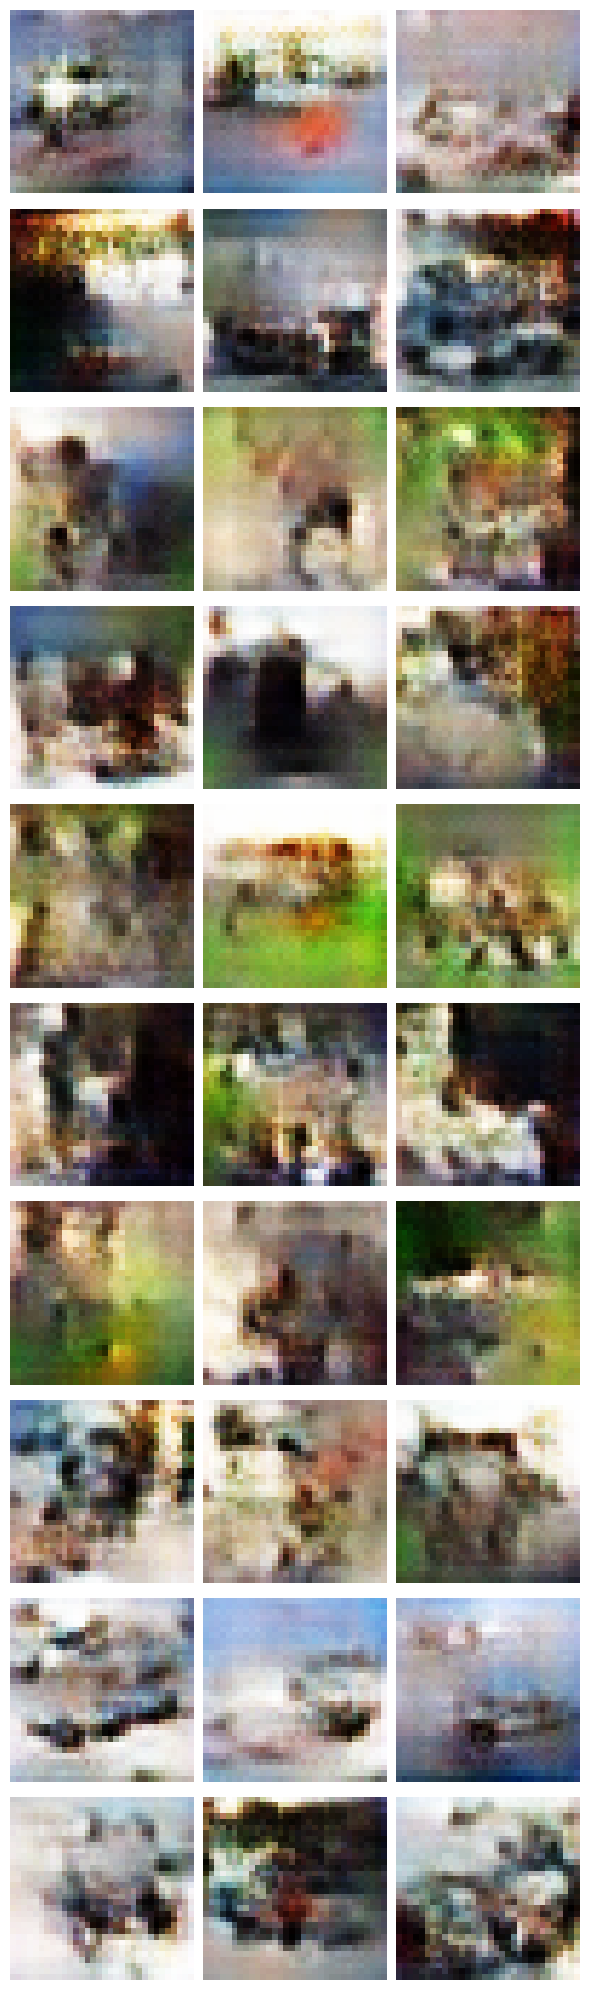


📦 Epoch 4/10


100%|██████████| 3125/3125 [00:44<00:00, 69.98it/s]


Generator Loss: 0.7773 | Discriminator Loss: 1.3548
⏱️ Time: 44.93s


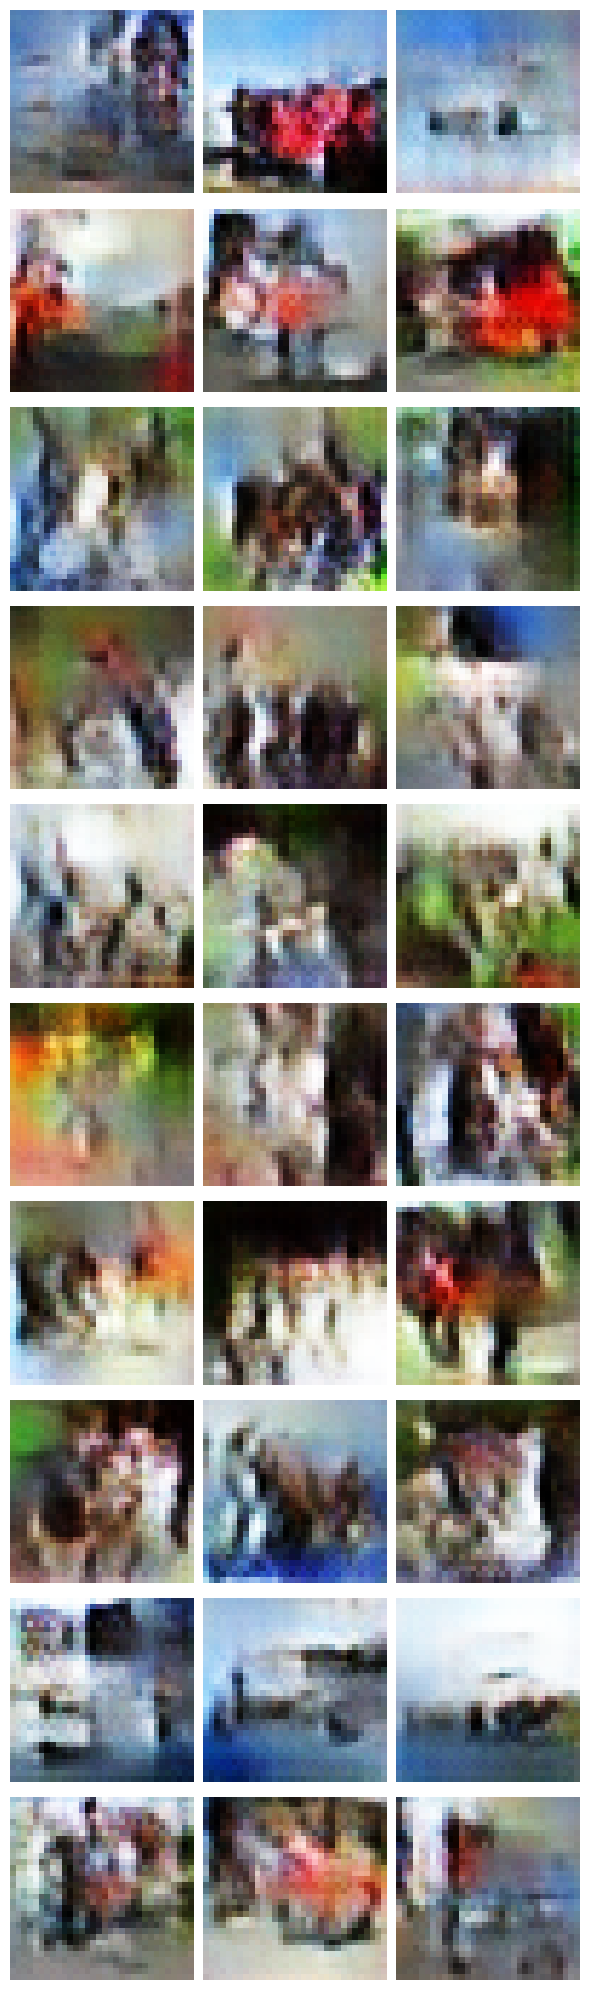


📦 Epoch 5/10


100%|██████████| 3125/3125 [00:44<00:00, 69.83it/s]


Generator Loss: 0.7718 | Discriminator Loss: 1.3555
⏱️ Time: 45.01s


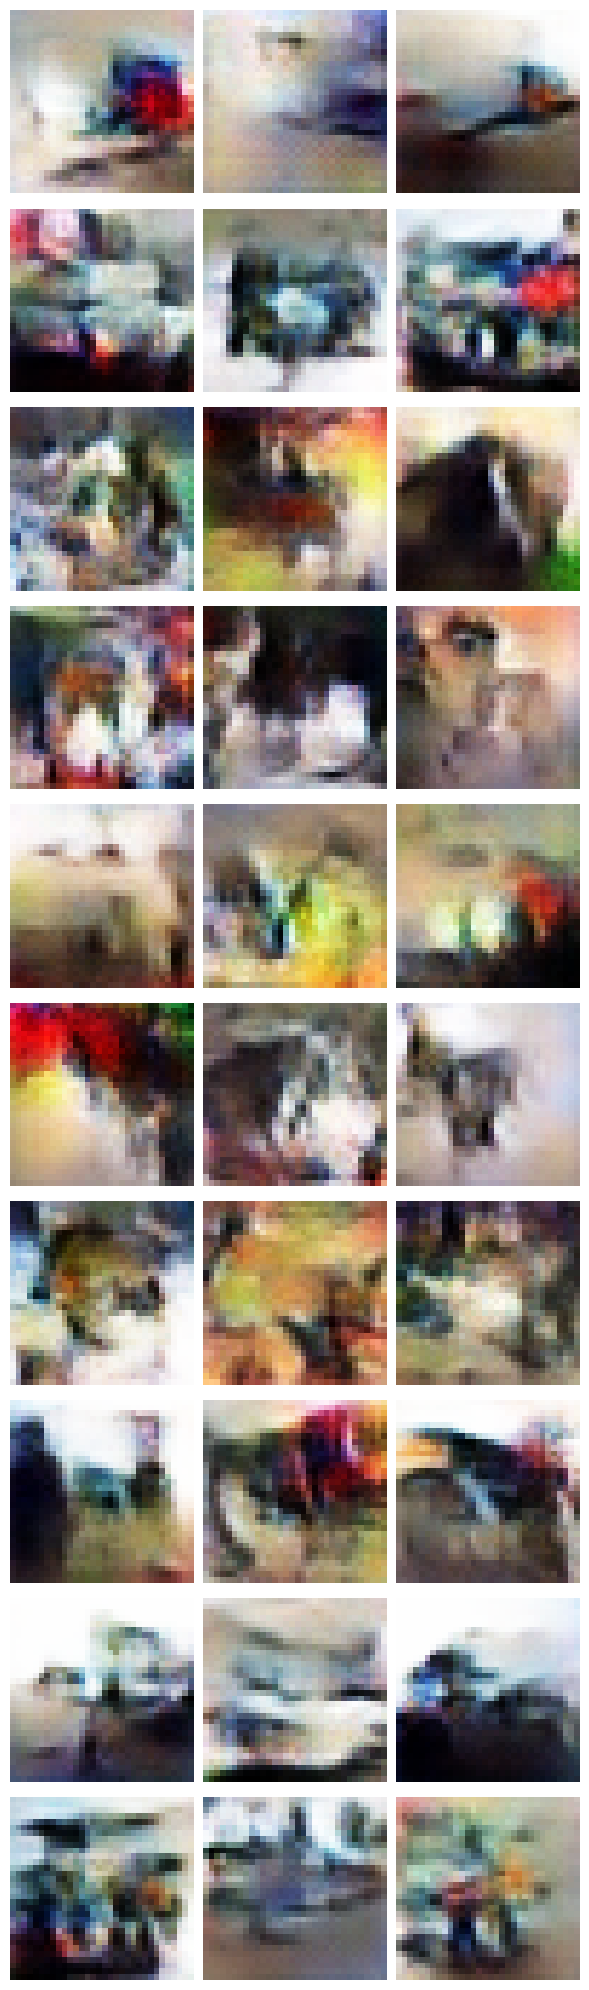


📦 Epoch 6/10


100%|██████████| 3125/3125 [00:44<00:00, 69.78it/s]


Generator Loss: 0.7696 | Discriminator Loss: 1.3613
⏱️ Time: 45.06s


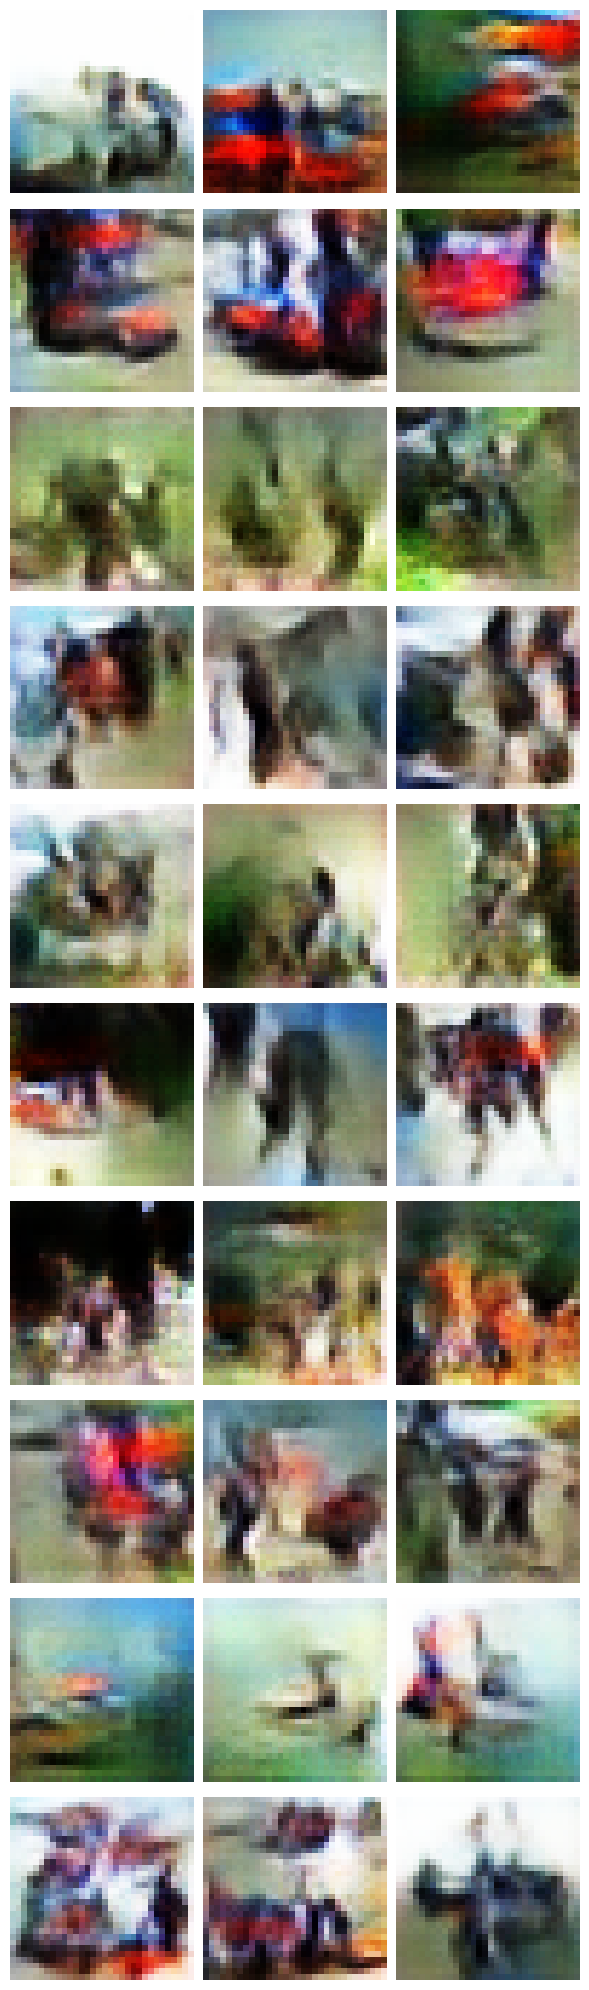


📦 Epoch 7/10


100%|██████████| 3125/3125 [00:44<00:00, 69.64it/s]


Generator Loss: 0.7626 | Discriminator Loss: 1.3620
⏱️ Time: 45.17s


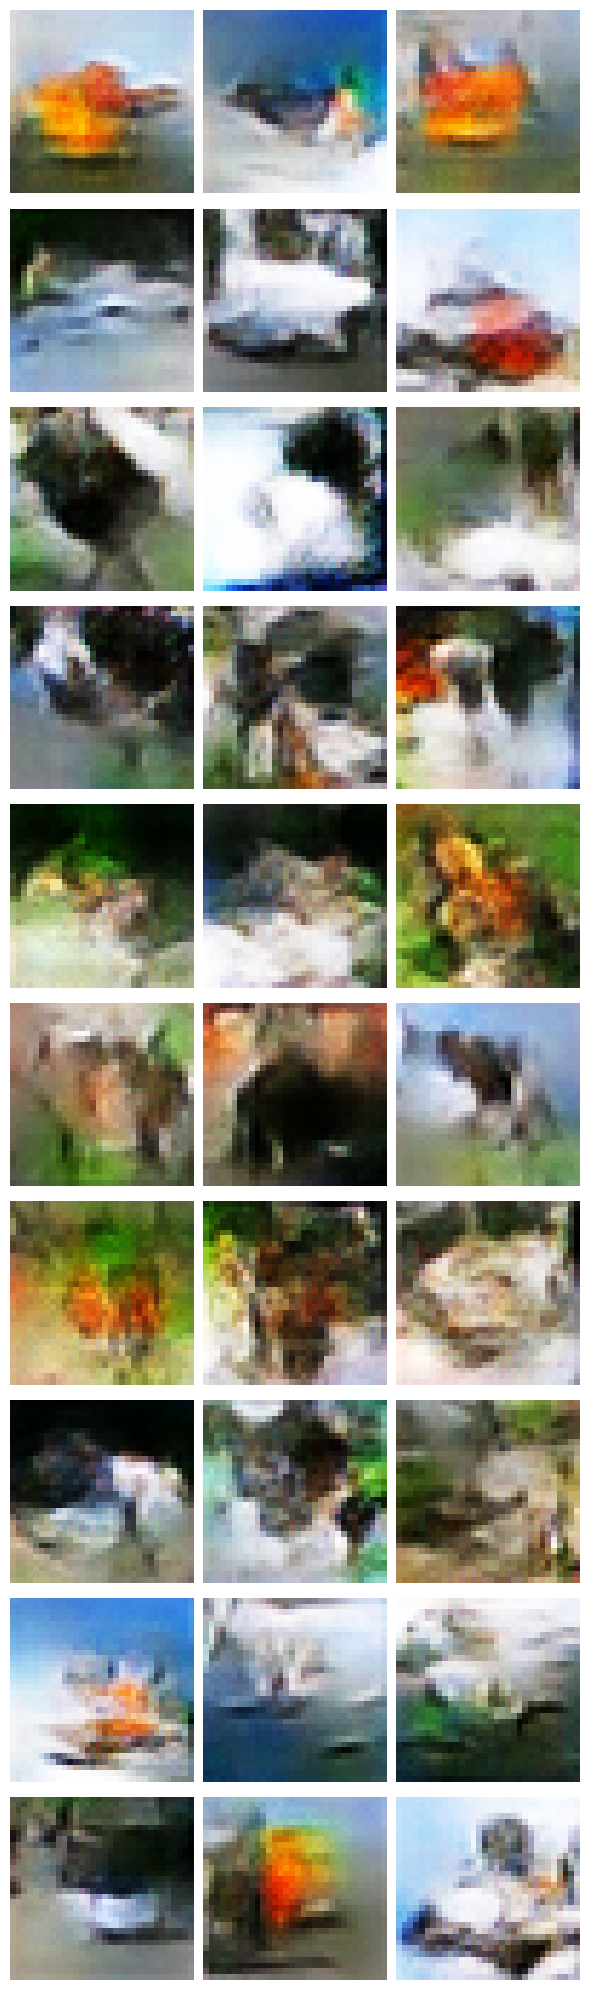


📦 Epoch 8/10


100%|██████████| 3125/3125 [00:44<00:00, 69.62it/s]


Generator Loss: 0.7599 | Discriminator Loss: 1.3626
⏱️ Time: 45.24s


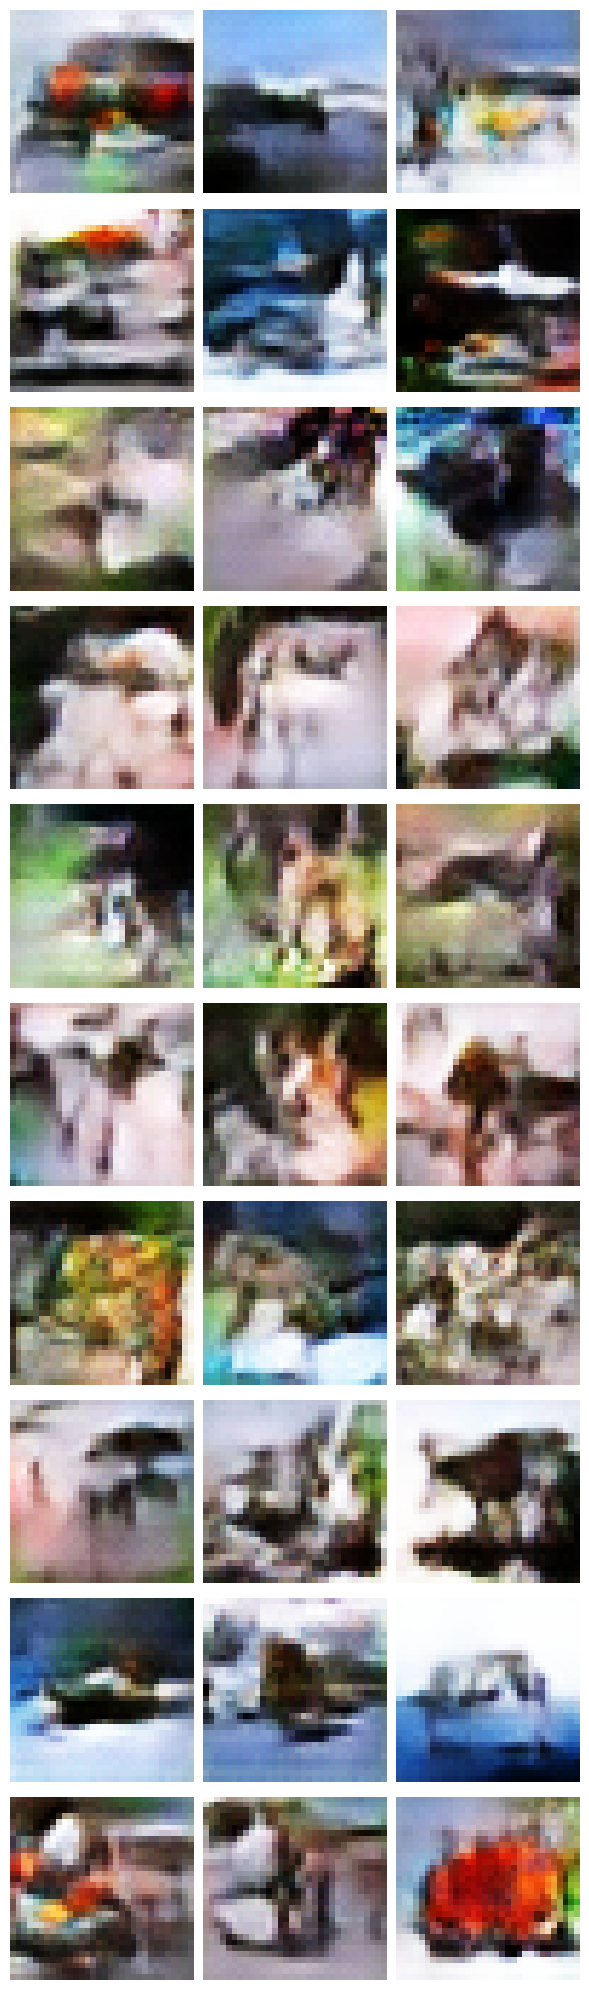


📦 Epoch 9/10


100%|██████████| 3125/3125 [00:44<00:00, 69.90it/s]


Generator Loss: 0.7601 | Discriminator Loss: 1.3618
⏱️ Time: 45.14s


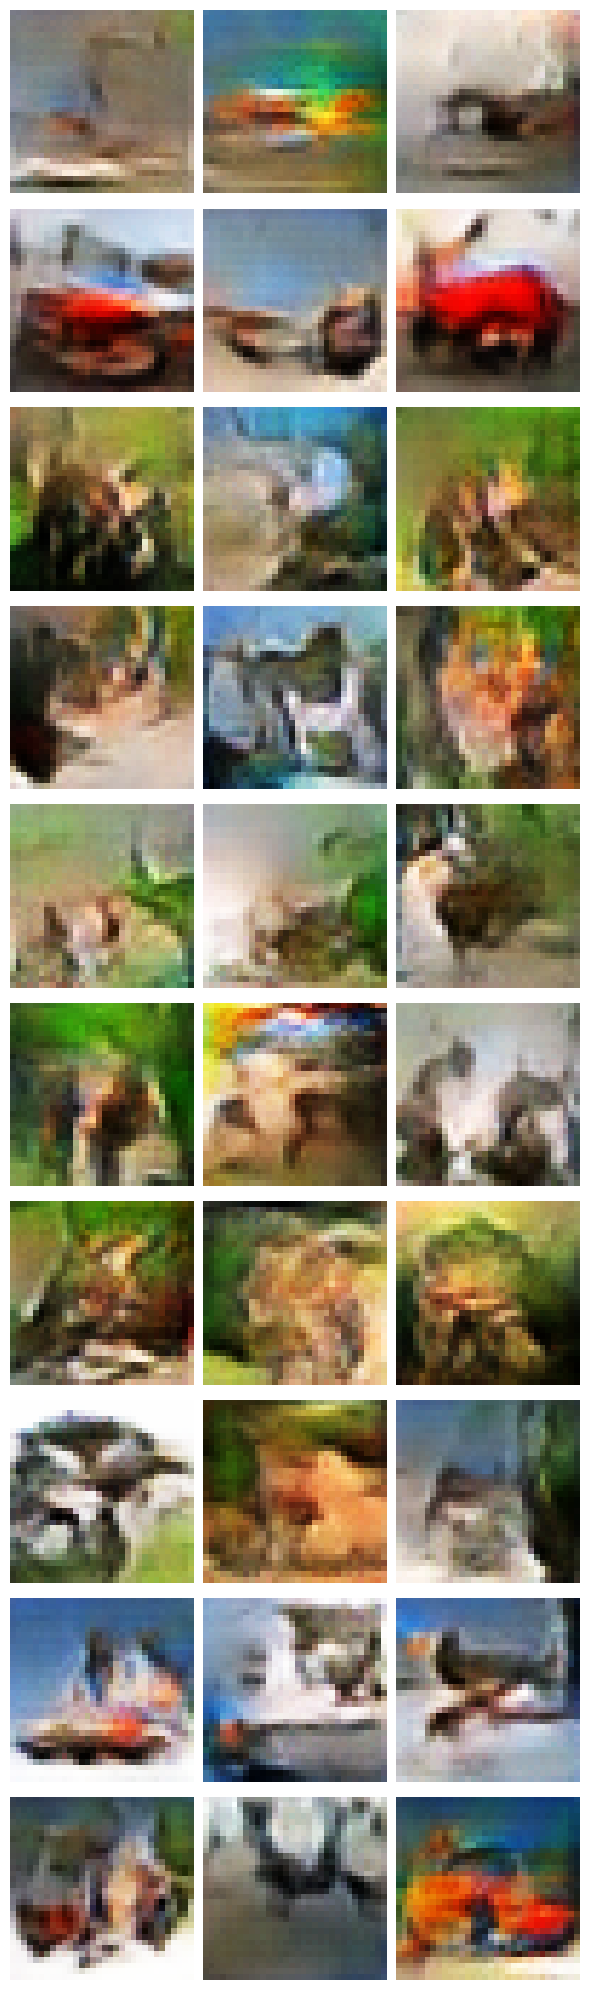


📦 Epoch 10/10


100%|██████████| 3125/3125 [00:44<00:00, 69.62it/s]


Generator Loss: 0.7634 | Discriminator Loss: 1.3583
⏱️ Time: 45.17s


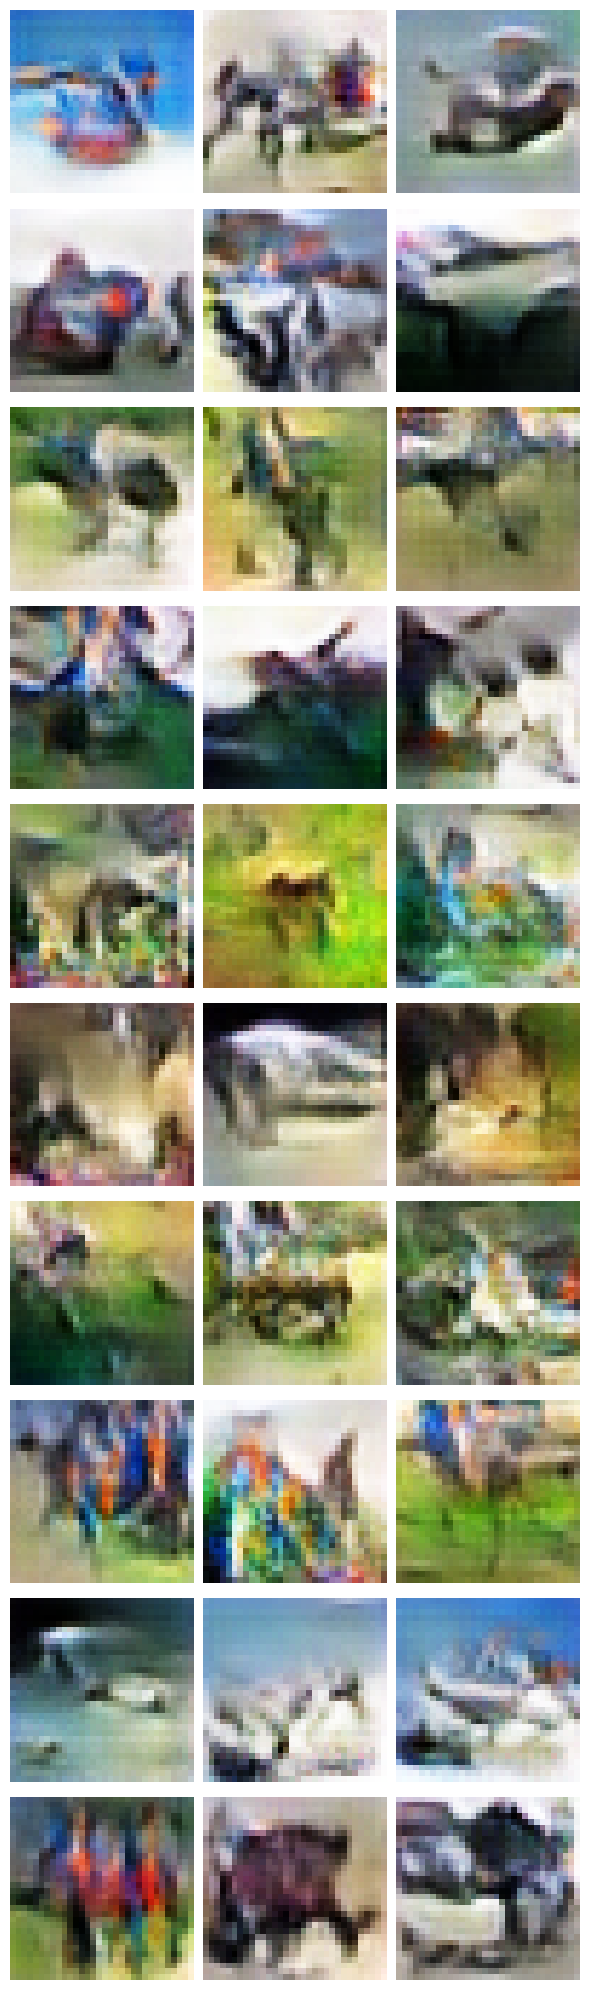

In [9]:
def train_gan(dataset, epochs):
    for ep in range(epochs):
        print(f"\n📦 Epoch {ep+1}/{epochs}")
        start_time = time.time()

        d_losses = []
        g_losses = []

        for batch_imgs, batch_labels in tqdm(dataset):
            d_loss, g_loss = step(batch_imgs, batch_labels)
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        print(f"Generator Loss: {np.mean(g_losses):.4f} | Discriminator Loss: {np.mean(d_losses):.4f}")
        print(f"⏱️ Time: {time.time() - start_time:.2f}s")
        display_generated(num_per_class=3)

# Start training
train_gan(train_data, EPOCHS)
